In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 


In [2]:
img = cv2.imread('test_imgs/barcode_1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [3]:
imgblur = cv2.GaussianBlur(gray, (3,3), 0)

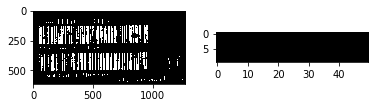

In [4]:
gradX = cv2.Sobel(imgblur, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(imgblur, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
sobelX = cv2.convertScaleAbs(gradX)
sobelY = cv2.convertScaleAbs(gradY)

grad = cv2.subtract(sobelX, sobelY)
sobel = cv2.convertScaleAbs(grad)

blurred = cv2.blur(sobel, (3, 3))
_, barcodeThresh = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)
barcodeKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 10))

plt.figure()
plt.subplot(121)
plt.imshow(barcodeThresh, cmap='gray')
plt.subplot(122)
plt.imshow(barcodeKernel, cmap='gray')


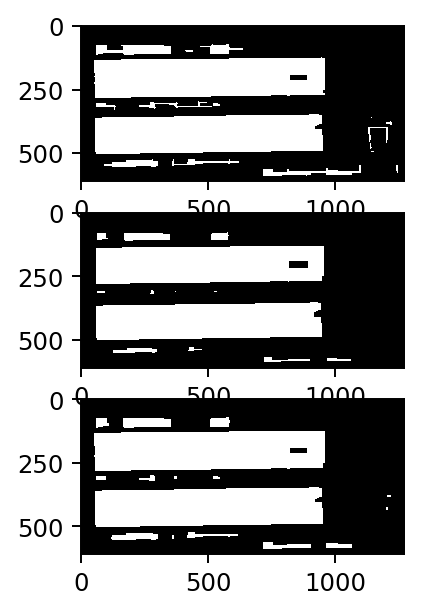

In [5]:
closed = cv2.morphologyEx(barcodeThresh, cv2.MORPH_CLOSE, barcodeKernel)
plt.figure(dpi=175)
plt.subplot(311)
plt.imshow(closed, cmap='gray')
closed = cv2.erode(closed, None, iterations=4)
plt.subplot(312)
plt.imshow(closed, cmap='gray')
closed = cv2.dilate(closed, None, iterations=4)
plt.subplot(313)
plt.imshow(closed, cmap='gray')
barcodeContours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [6]:
barcodeCnt1 = sorted(barcodeContours, key=cv2.contourArea, reverse=True)[0]
barcodeCnt2 = sorted(barcodeContours, key=cv2.contourArea, reverse=True)[1]
center1, size1, angle1 = cv2.minAreaRect(barcodeCnt1)
center2, size2, angle2 = cv2.minAreaRect(barcodeCnt2)

In [20]:
rotated = cv2.getRotationMatrix2D(center2, angle2, 1)
rows, cols, _ = img.shape
rotatedImage = cv2.warpAffine(img, rotated, (cols, rows))
rotated

array([[ 0.999895  , -0.01449123,  6.2625674 ],
       [ 0.01449123,  0.999895  , -7.22299259]])

In [8]:
if abs(angle1) > 45:
    rect1 = (center1, size1, 90)
    box1 = np.int0(cv2.boxPoints(rect1))
    temp = [[0, 0]]*4
    for i in range(0, 3):
        temp[i+1] = box1[i]
    temp[0] = box1[3]
    box1 = np.array(temp)
    cv2.drawContours(rotatedImage, [box1], -1, (255, 0, 0), 2)
else:
    rect1 = (center1, size1, 0)
    box1 = np.int0(cv2.boxPoints(rect1))
    cv2.drawContours(rotatedImage, [box1], -1, (255, 0, 0), 2)

if abs(angle2) > 45:
    rect2 = (center2, size2, 90)
    box2 = np.int0(cv2.boxPoints(rect2))
    temp = [[0, 0]]*4
    for i in range(0, 3):
        temp[i+1] = box2[i]
    temp[0] = box2[3]
    box2 = np.array(temp)
    cv2.drawContours(rotatedImage, [box2], -1, (255, 0, 0), 2)
else:
    rect2 = (center2, size2, 0)
    box2 = np.int0(cv2.boxPoints(rect2))
    cv2.drawContours(rotatedImage, [box2], -1, (255, 0, 0), 2)

True

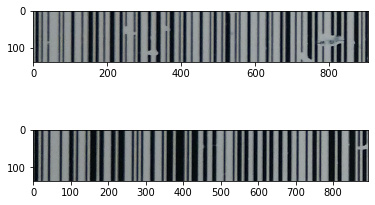

In [23]:
ROI1 = rotatedImage[box1[1][1]+5:box1[0][1]-5, box1[1][0]:box1[2][0]]
ROI2 = rotatedImage[box2[1][1]+5:box2[0][1]-5, box2[1][0]:box2[2][0]]
plt.subplot(211)
plt.imshow(ROI1)
plt.subplot(212)
plt.imshow(ROI2)
cv2.imwrite('ROI1.jpg', ROI1)
cv2.imwrite('ROI2.jpg', ROI2)

In [10]:
def detect(ROI):
    defectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
    eroded = cv2.erode(ROI, defectKernel)
    defect = cv2.subtract(ROI, eroded)
    _, defectThresh = cv2.threshold(defect, 25, 255, cv2.THRESH_BINARY)
    # cv2.imshow("defectThresh Image", defectThresh);
    b, g, r = cv2.split(defectThresh)
    merged = cv2.merge([r-r, r-r, r])
    defectGray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
    _, defectGray = cv2.threshold(defectGray, 50, 255, cv2.THRESH_BINARY)
    defectContours, _ = cv2.findContours(defectGray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for ci in defectContours:
        if cv2.contourArea(ci) < 10:
            continue
        x, y, w, h = cv2.boundingRect(ci)
        cv2.rectangle(ROI, (x, y), (x+w, y+h), (0, 0, 255), 2)



True

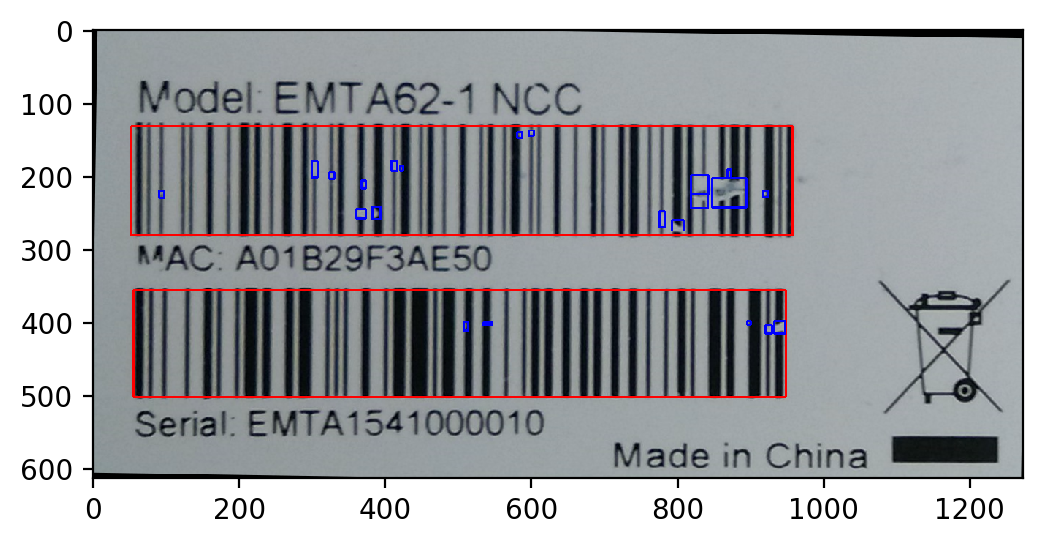

In [11]:
detect(ROI1)
detect(ROI2)
plt.figure(dpi=200)
plt.imshow(rotatedImage)
cv2.imwrite('res/res1.png', rotatedImage)

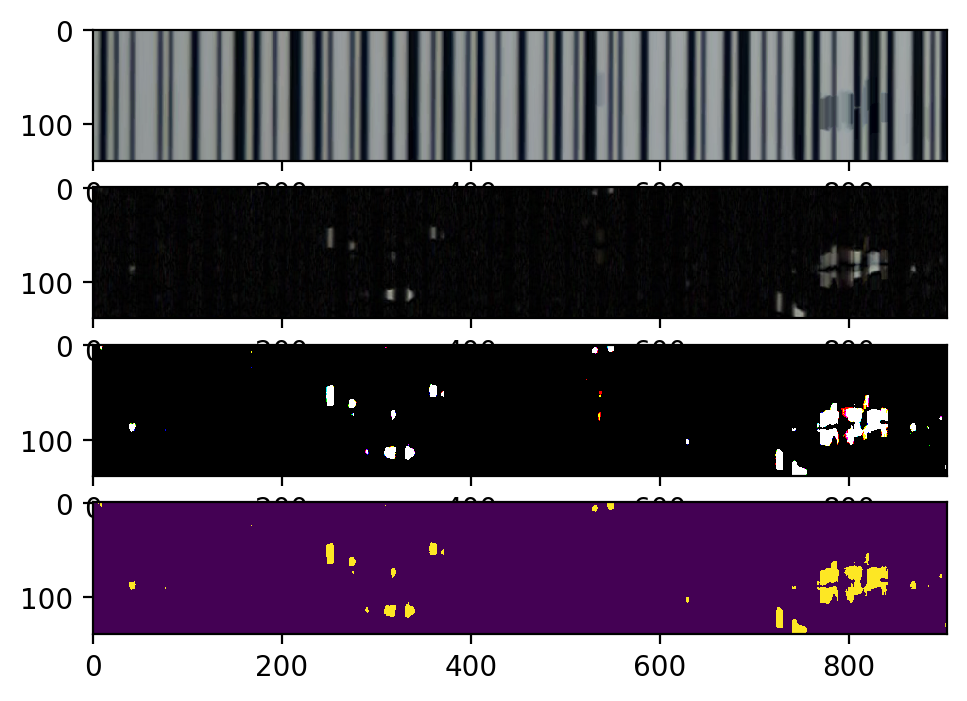

In [18]:
ROI = ROI1
defectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
eroded = cv2.erode(ROI, defectKernel)

plt.figure(dpi=200)
plt.subplot(411)
plt.imshow(eroded)
defect = cv2.subtract(ROI, eroded)


plt.subplot(412)
plt.imshow(defect)

_, defectThresh = cv2.threshold(defect, 25, 255, cv2.THRESH_BINARY)

plt.subplot(413)
plt.imshow(defectThresh)

b, g, r = cv2.split(defectThresh)
merged = cv2.merge([r-r, r-r, r])
defectGray = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
_, defectGray = cv2.threshold(defectGray, 50, 255, cv2.THRESH_BINARY)

plt.subplot(414)
plt.imshow(defectGray)

defectContours, _ = cv2.findContours(defectGray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for ci in defectContours:
    if cv2.contourArea(ci) < 10:
        continue
    x, y, w, h = cv2.boundingRect(ci)
    cv2.rectangle(ROI, (x, y), (x+w, y+h), (0, 0, 255), 2)

In [25]:
se = cv2.getStructuringElement(cv2.MORPH_RECT, (3,5))
se.shape

(5, 3)